<h1> Exercises </h1>
In this notebook we have a few exercises and examples of code such that you can run it, play around with it to better understand how radar signal processing is performed in Python. 

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import processing.save_adc_data as sd
import processing._process_data as pd


<h5> 1. Setting up Paths and Loading Data: </h5>
To load your data, please make sure the file paths are all correct. The variables/functions are setup expecting a specific way of your project directory organization, however it is up to you how you want to organize it. Step through these variables to make sure you are loading what is expected. 

In the end, it is up to you how you want to link the paths. We've set it up in a way that should work if you follow the path conventions however you are welcome to look through all the functions called in order to determine how you want to input path names.

In [2]:
# TODO: Put the *name* of your .bin file here (excluding the .bin)
filename = r"1"
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"
# TODO: Put the path (relative to home_dir) of the captured data folder
capture_data_dir = r"data"
# TODO: Put the path (relative to home_dir) and name of the JSON files (exlude the .setup.json and .mmwave.json)
json_filename = r"scripts/chirp1"
path_to_rawdata = os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat')
bin_data = sio.loadmat(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat'))

Loading the data requires loading the *.bin file you measured and converting it to a *.mat file. You only have to do this conversion once if the data has not changed in that file. Then we load the *.mat file and extract the raw data.

In [3]:
############################# Reformat the Data #############################
if not os.path.exists(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat')):
    sd.save_adc_data(filename, home_dir, capture_data_dir, json_filename)

################################# load data #################################
bin_data = sio.loadmat(os.path.join(home_dir,capture_data_dir,"rdc_" + filename + '.mat'))
raw_data = np.array(bin_data['data_raw'])

print("You captured %d frames, for %d TX, %d Rx, and %d adc samples" % raw_data.shape)

You captured 20 frames, for 3 TX, 4 Rx, and 512 adc samples


<h5> 2. Range FFT: </h5> 

There is some simple signal processing we can do to have a coarse understanding of what we've received. Below, is code for processing and plotting the range FFT as you have seen in the lectures. Based on this you should also be able to locate the strongest reflector and recover the distance of that reflector. 

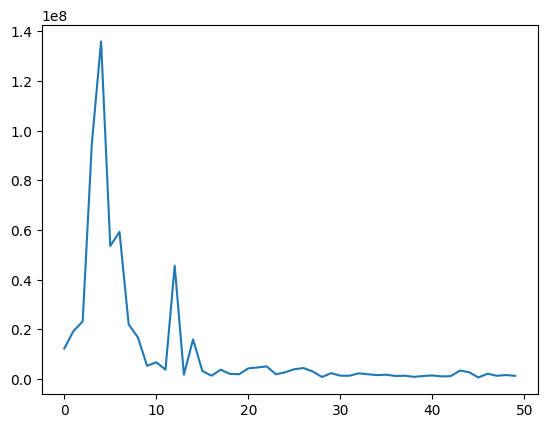

In [4]:
############################### process data! ################################
# Range FFT
rfft = scipy.fft.fft(raw_data, axis=3)
plt.plot(abs(np.squeeze(np.sum(rfft[:,:,:,0:50],axis=(0,2,1)))))


In [ ]:
######## Find the distance of the maximum reflector in front of the radar. #############
# TODO: add your code here

<h5> 3. Beamforming </h5>

To help understand some of the ways to visualize radar data better especially in 2D or 3D, we have provided some processed data and some examples of Python plotting code to play around with. First we will go through the process of beamforming and show the heatmaps we can recover from this.

In [50]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

filename = r"BF_data"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))

# define the antenna spacing
lm = 3e8/77e9 # define lambda for the antenna spacing
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1))
x_pos = (np.reshape(np.arange(1,81,dtype=float),(-1,1)) * lm).T
ant_pos = rx_pos * x_pos 
ant_pos = np.reshape(ant_pos,(-1,1))

raw_data = mat_data['adcData']

for ii in range(raw_data.shape[0]):
    raw_data[ii,:] = pd.butter_highpass_filter(raw_data[ii,:],350000,10e6)

In [52]:
# just look at one vertical dimension since we are not using phi
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape
X = raw_data[:,num_z_stp//2,:,:,:]
locs = ant_pos
beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq,(num_x_stp * num_rx, adc_samples))

In [53]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
theta_s, theta_e = 40, 140
# resolution of the angles
theta_res = 2

# Convert everything to Radians 
theta_s *= (np.pi/180)
theta_e *= (np.pi/180)
theta_res*= (np.pi/180)
theta_rad_lim = [theta_s,theta_e]

# Generate arrays for theta 
theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
N_theta = len(theta)

# Initialize arrays for spherical power
sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

print("Running this many iterations: %d " % (N_theta))

######################## BF Calculations ###########################3
for kt in range(N_theta):
        sin_theta = np.sin(theta[kt])
        Vec = np.exp(1j*(2*np.pi*(locs*sin_theta)/lm)) 
        VecRFI = np.repeat(Vec[:, np.newaxis], adc_samples, axis=1)
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(beat_freq[:, 0:adc_samples], np.squeeze(VecRFI)), axis=(0)))
        print("Processed angle (%.2f)" % (theta[kt]*180/np.pi), end='\r')


Running this many iterations: 50 


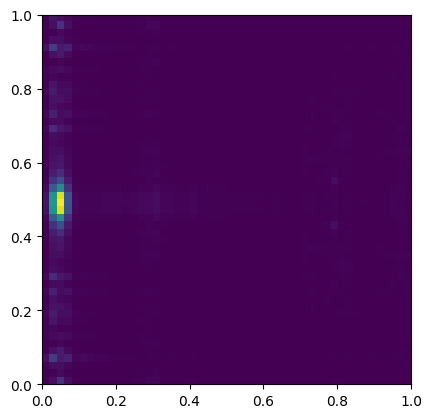

In [55]:
plt.imshow(abs(sph_pwr[:,0:50]), extent=[0, 1, 0, 1])


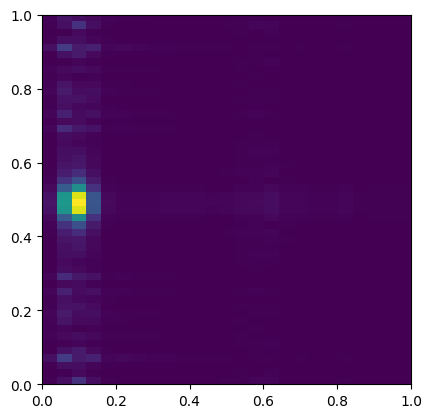

In [56]:
plt.imshow(abs(sph_pwr[:,0:25]), extent=[0, 1, 0, 1])


Once we've performed beamforming on this 1D array, we can plot the corresponding images. In this example below, we have plotted the birds eye view for you. You can play around with the normalization to see how different thresholds impact the final image and what reflectors you can see. 

<h5> 4. Matched Filter:</h5> 

Find the distance of the maximum reflector in the enivornment for the two data files provided. Show your code and print out the values in the next cell.

<h5>Exercise 2:</h5> Now you will have to fill in some code we provide for different methods of radar imaging. Here we have given you the skeleton of the code for a 2D beamforming algorithm which you must fill in to get the 2D heatmap of the scene in polar coordinates.

In [ ]:
######## 2D Imaging in Polar #############


Now finish the code for a 2D matched filter algorithm for 2D heatmap of the scene in cartesian coordinates.

In [ ]:
######## 2D Imaging in Cartesian #############

Finally, we will perform matched filter on multiple depths in the enivornment. Finish the code in order to view the imaged items in 3D!

In [ ]:
######## 3D Imaging in Polar #############